### ***1. Reading the data***

The pop layer crs is: epsg:3879


Index(['pop18', 'geometry'], dtype='object')

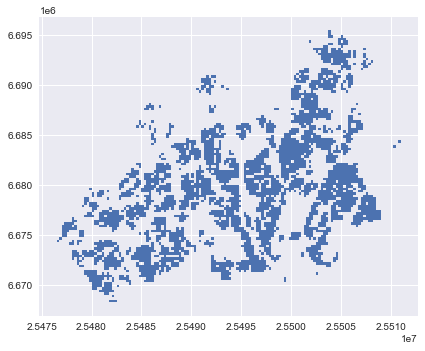

In [53]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

# POPULATION LAYER

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# definying the crs.  ETRS GK-25 (EPSG:3879) because we know what it is based on the population grid metadata.
pop.crs = CRS.from_epsg(3879)

# Subset columns
pop = pop[["pop18", "geometry"]]

print('The pop layer crs is: {}'.format(pop.crs))
pop.plot()
pop.columns

The grid layer crs is: ETRS89 / TM35FIN(E,N)


,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


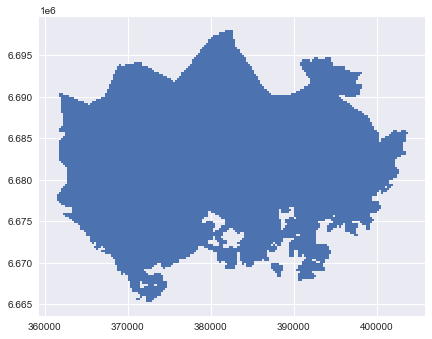

In [54]:
import glob
import pandas as pd

#GRID FOR TRAVEL TIMES

# reading grid
grid_path = r'data\YKR_grid.shp'
grid = gpd.read_file(grid_path)

print('The grid layer crs is: {}'.format(grid.crs.name))
grid.plot();
grid.head()

The crs is: ETRS89 / TM35FIN(E,N)


<AxesSubplot:>

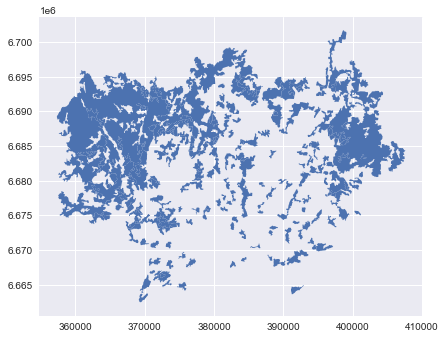

In [55]:
# GREEN AREAS

# reading files
green_path = r'data/green_areas_HMA.gpkg'
green = gpd.read_file(green_path)

print('The crs is: {}'.format(green.crs.name))
green.plot()

In [56]:
# TRAVEL TIMES TO GREEN AREAS

# reading files
filepaths = glob.glob(r"data/travel_times*.txt")

filepaths

['data\\travel_times_to_ 5861358.txt',
 'data\\travel_times_to_ 5870551.txt',
 'data\\travel_times_to_ 5892859.txt',
 'data\\travel_times_to_ 5934915.txt',
 'data\\travel_times_to_ 5954808.txt',
 'data\\travel_times_to_ 5967121.txt']

### ***2. Joining travel time by: car, public transport, walking, cycling***

In [57]:
# CAR

# reading files
name_columns = ['car_r_t_Sipoonkorpi', 'car_r_t_Nuuksio', 'car_r_t_Haltialan', 
                'car_r_t_Urban', 'car_r_t_Kallalahdenharju', 'car_r_t_Espoo']

# creating a new grid for only car (dominant areas)
grid_car = grid.copy()

# iterates over files and name colums, to join in grid
for file, namecol in zip(filepaths, name_columns):
    
    # reads files and rename colums to join easily
    data = pd.read_csv(file, sep=';', usecols=['from_id', 'car_r_t']).rename(columns={'car_r_t':namecol, 'from_id': 'YKR_ID'})
    
    # join car travel times
    grid_car = grid_car.merge(data, on = 'YKR_ID')
    
grid_car.head()

,x,y,YKR_ID,geometry,car_r_t_Sipoonkorpi,car_r_t_Nuuksio,car_r_t_Haltialan,car_r_t_Urban,car_r_t_Kallalahdenharju,car_r_t_Espoo
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",54,67,39,42,69,64
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",51,70,42,44,68,66
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",51,70,42,44,68,66
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",51,70,42,44,68,66
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",54,67,39,41,68,63


In [58]:
import numpy as np

# removing no data
print('all data has {} records'.format(len(grid_car)))

grid_car = grid_car.replace(-1, np.nan).dropna()

print('removed null has {} records'.format(len(grid_car)))

all data has 13231 records
removed null has 13066 records


In [59]:
# PUBLIC TRANSPORTATION

# reading files
name_columns = ['pt_r_tt_Sipoonkorpi', 'pt_r_tt_Nuuksio', 'pt_r_tt_Haltialan', 
                'pt_r_tt_Urban', 'pt_r_tt_Kallalahdenharju', 'pt_r_tt_Espoo']

# creating a new grid for only car (dominant areas)
grid_pt = grid.copy()

# iterates over files and name colums, to join in grid
for file, namecol in zip(filepaths, name_columns):
    
    # reads files and rename colums to join easily
    data = pd.read_csv(file, sep=';', usecols=['from_id', 'pt_r_tt']).rename(columns={'pt_r_tt':namecol, 'from_id': 'YKR_ID'})
    
    # join car travel times
    grid_pt = grid_pt.merge(data, on = 'YKR_ID')
    
grid_pt.head()

,x,y,YKR_ID,geometry,pt_r_tt_Sipoonkorpi,pt_r_tt_Nuuksio,pt_r_tt_Haltialan,pt_r_tt_Urban,pt_r_tt_Kallalahdenharju,pt_r_tt_Espoo
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",151,224,154,132,169,183
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",162,232,162,141,177,190
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",166,232,166,143,181,193
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",172,239,175,149,190,204
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",151,217,154,128,168,181


In [60]:
# removing no data
print('all data has {} records'.format(len(grid_pt)))

grid_pt = grid_pt.replace(-1, np.nan).dropna()

print('removed null has {} records'.format(len(grid_pt)))

all data has 13231 records
removed null has 13104 records


In [61]:
# WALKING

# reading files
name_columns = ['walk_t_Sipoonkorpi', 'walk_t_Nuuksio', 'walk_t_Haltialan', 
                'walk_t_Urban', 'walk_t_Kallalahdenharju', 'walk_t_Espoo']

# creating a new grid for only car (dominant areas)
grid_wa = grid.copy()

# iterates over files and name colums, to join in grid
for file, namecol in zip(filepaths, name_columns):
    
    # reads files and rename colums to join easily
    data = pd.read_csv(file, sep=';', usecols=['from_id', 'walk_t']).rename(columns={'walk_t':namecol, 'from_id': 'YKR_ID'})
    
    # join car travel times
    grid_wa = grid_wa.merge(data, on = 'YKR_ID')
    
grid_wa.head()

,x,y,YKR_ID,geometry,walk_t_Sipoonkorpi,walk_t_Nuuksio,walk_t_Haltialan,walk_t_Urban,walk_t_Kallalahdenharju,walk_t_Espoo
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",366,471,333,368,539,478
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",352,468,296,330,502,459
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",354,469,297,331,503,460
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",358,474,301,335,507,464
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",359,464,326,361,532,471


In [62]:
# removing no data
print('all data has {} records'.format(len(grid_wa)))

grid_wa = grid_wa.replace(-1, np.nan).dropna()

print('removed null has {} records'.format(len(grid_wa)))

all data has 13231 records
removed null has 11890 records


In [63]:
# BIKE FAST SPEED

# reading files
name_columns = ['bike_f_t_Sipoonkorpi', 'bike_f_t_Nuuksio', 'bike_f_t_Haltialan', 
                'bike_f_t_Urban', 'bike_f_t_Kallalahdenharju', 'bike_f_t_Espoo']


# creating a new grid for only car (dominant areas)
grid_bi = grid.copy()

# iterates over files and name colums, to join in grid
for file, namecol in zip(filepaths, name_columns):
    
    # reads files and rename colums to join easily
    data = pd.read_csv(file, sep=';', usecols=['from_id', 'bike_s_t']).rename(columns={'bike_s_t':namecol, 'from_id': 'YKR_ID'})
    
    # join car travel times
    grid_bi = grid_bi.merge(data, on = 'YKR_ID')
    
grid_bi.head()

,x,y,YKR_ID,geometry,bike_f_t_Sipoonkorpi,bike_f_t_Nuuksio,bike_f_t_Haltialan,bike_f_t_Urban,bike_f_t_Kallalahdenharju,bike_f_t_Espoo
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",114,136,94,104,158,141
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",120,159,91,103,154,146
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",120,159,91,103,154,146
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",100,160,97,112,146,155
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",111,133,91,101,155,138


In [64]:
# removing no data
print('all data has {} records'.format(len(grid_bi)))

grid_bi = grid_bi.replace(-1, np.nan).dropna()

print('removed null has {} records'.format(len(grid_bi)))

all data has 13231 records
removed null has 13168 records


### ***3. Creating dominant areas by transportation mode***

,x,y,YKR_ID,geometry,car_r_t_Sipoonkorpi,car_r_t_Nuuksio,car_r_t_Haltialan,car_r_t_Urban,car_r_t_Kallalahdenharju,car_r_t_Espoo,min_t_car,car_dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",54.0,67.0,39.0,42.0,69.0,64.0,39.0,Haltialan
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",51.0,70.0,42.0,44.0,68.0,66.0,42.0,Haltialan
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",51.0,70.0,42.0,44.0,68.0,66.0,42.0,Haltialan
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",51.0,70.0,42.0,44.0,68.0,66.0,42.0,Haltialan
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",54.0,67.0,39.0,41.0,68.0,63.0,39.0,Haltialan


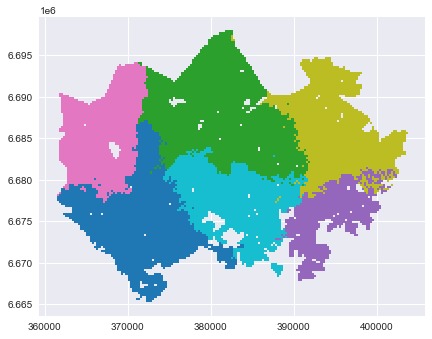

In [65]:
# CAR

# Define value columns
value_columns = ['car_r_t_Sipoonkorpi', 'car_r_t_Nuuksio', 'car_r_t_Haltialan', 
                'car_r_t_Urban', 'car_r_t_Kallalahdenharju', 'car_r_t_Espoo']

# Create a new column for minimum travel time values 
grid_car['min_t_car'] = grid_car[value_columns].min(axis = 1)

# Create a new column for the closest shopping center id values
grid_car['car_dominant_service'] = (grid_car[value_columns].idxmin(axis = 1))

# Include the name of the park
grid_car['car_dominant_service'] = [park.split('_')[-1] for park in grid_car['car_dominant_service']]

grid_car.plot(column = 'car_dominant_service');
grid_car.head()

,x,y,YKR_ID,geometry,pt_r_tt_Sipoonkorpi,pt_r_tt_Nuuksio,pt_r_tt_Haltialan,pt_r_tt_Urban,pt_r_tt_Kallalahdenharju,pt_r_tt_Espoo,min_t_pt,pt_dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",151.0,224.0,154.0,132.0,169.0,183.0,132.0,Urban
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",162.0,232.0,162.0,141.0,177.0,190.0,141.0,Urban
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",166.0,232.0,166.0,143.0,181.0,193.0,143.0,Urban
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",172.0,239.0,175.0,149.0,190.0,204.0,149.0,Urban
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",151.0,217.0,154.0,128.0,168.0,181.0,128.0,Urban


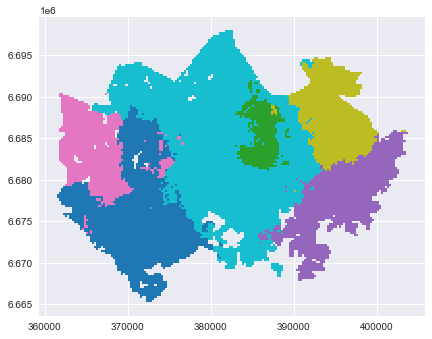

In [66]:
# PUBLIC TRANSPORT

# Define value columns
value_columns = ['pt_r_tt_Sipoonkorpi', 'pt_r_tt_Nuuksio', 'pt_r_tt_Haltialan', 
                'pt_r_tt_Urban', 'pt_r_tt_Kallalahdenharju', 'pt_r_tt_Espoo']

# Create a new column for minimum travel time values 
grid_pt['min_t_pt'] = grid_pt[value_columns].min(axis = 1)

# Create a new column for the closest shopping center id values
grid_pt['pt_dominant_service'] = (grid_pt[value_columns].idxmin(axis = 1))

# Include the name of the park
grid_pt['pt_dominant_service'] = [park.split('_')[-1] for park in grid_pt['pt_dominant_service']]

grid_pt.plot(column = 'pt_dominant_service');
grid_pt.head()

,x,y,YKR_ID,geometry,walk_t_Sipoonkorpi,walk_t_Nuuksio,walk_t_Haltialan,walk_t_Urban,walk_t_Kallalahdenharju,walk_t_Espoo,min_t_wa,wa_dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",366.0,471.0,333.0,368.0,539.0,478.0,333.0,Haltialan
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",352.0,468.0,296.0,330.0,502.0,459.0,296.0,Haltialan
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",354.0,469.0,297.0,331.0,503.0,460.0,297.0,Haltialan
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",358.0,474.0,301.0,335.0,507.0,464.0,301.0,Haltialan
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",359.0,464.0,326.0,361.0,532.0,471.0,326.0,Haltialan


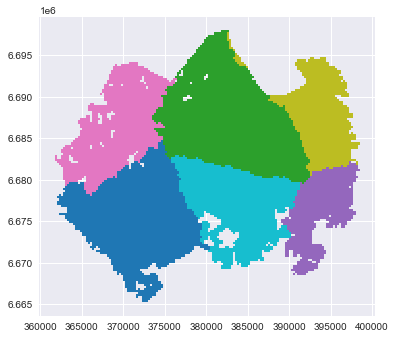

In [67]:
# WALKING

# Define value columns
value_columns = ['walk_t_Sipoonkorpi', 'walk_t_Nuuksio', 'walk_t_Haltialan', 
                'walk_t_Urban', 'walk_t_Kallalahdenharju', 'walk_t_Espoo']

# Create a new column for minimum travel time values 
grid_wa['min_t_wa'] = grid_wa[value_columns].min(axis = 1)

# Create a new column for the closest shopping center id values
grid_wa['wa_dominant_service'] = (grid_wa[value_columns].idxmin(axis = 1))

# Include the name of the park
grid_wa['wa_dominant_service'] = [park.split('_')[-1] for park in grid_wa['wa_dominant_service']]

grid_wa.plot(column = 'wa_dominant_service');
grid_wa.head()

,x,y,YKR_ID,geometry,bike_f_t_Sipoonkorpi,bike_f_t_Nuuksio,bike_f_t_Haltialan,bike_f_t_Urban,bike_f_t_Kallalahdenharju,bike_f_t_Espoo,min_t_bi,bi_dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",114.0,136.0,94.0,104.0,158.0,141.0,94.0,Haltialan
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",120.0,159.0,91.0,103.0,154.0,146.0,91.0,Haltialan
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",120.0,159.0,91.0,103.0,154.0,146.0,91.0,Haltialan
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",100.0,160.0,97.0,112.0,146.0,155.0,97.0,Haltialan
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",111.0,133.0,91.0,101.0,155.0,138.0,91.0,Haltialan


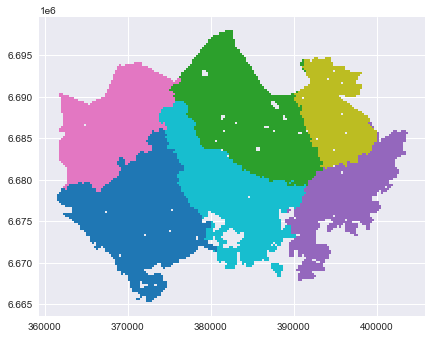

In [68]:
# BIKE FAST SPEED

# Define value columns
value_columns = ['bike_f_t_Sipoonkorpi', 'bike_f_t_Nuuksio', 'bike_f_t_Haltialan', 
                'bike_f_t_Urban', 'bike_f_t_Kallalahdenharju', 'bike_f_t_Espoo']

# Create a new column for minimum travel time values 
grid_bi['min_t_bi'] = grid_bi[value_columns].min(axis = 1)

# Create a new column for the closest shopping center id values
grid_bi['bi_dominant_service'] = (grid_bi[value_columns].idxmin(axis = 1))

# Include the name of the park
grid_bi['bi_dominant_service'] = [park.split('_')[-1] for park in grid_bi['bi_dominant_service']]

grid_bi.plot(column = 'bi_dominant_service');
grid_bi.head()

### ***4. Adding population info to Dominant Areas***

In [69]:
# check crs
grid.crs.name

'ETRS89 / TM35FIN(E,N)'

In [70]:
# projecting data

# definying the crs.  ETRS GK-25 (EPSG:3879) because we know what it is based on the population grid metadata.
#pop.crs = CRS.from_epsg(3879)

# POP LAYER
pop = pop.to_crs(epsg=grid.crs.to_epsg())

# GREEN AREA LAYER
green = green.to_crs(epsg=grid.crs.to_epsg())

pop.crs == green.crs == grid.crs

True

In [71]:
# aggregating dominance areas
grid_car = grid_car.dissolve(by = 'car_dominant_service')[['geometry']]

grid_pt = grid_pt.dissolve(by = 'pt_dominant_service')[['geometry']]

grid_wa = grid_wa.dissolve(by = 'wa_dominant_service')[['geometry']]

grid_bi = grid_bi.dissolve(by = 'bi_dominant_service')[['geometry']]

grid_bi.head()

,geometry
bi_dominant_service,
Espoo,"MULTIPOLYGON (((373000.000 6665250.000, 372750..."
Haltialan,"MULTIPOLYGON (((391750.000 6679250.000, 391500..."
Kallalahdenharju,"MULTIPOLYGON (((391000.000 6667750.000, 390750..."
Nuuksio,"POLYGON ((366750.000 6678500.000, 366500.000 6..."
Sipoonkorpi,"POLYGON ((394000.000 6681250.000, 393750.000 6..."


,pop18,geometry,index_right
0,108,MULTIPOLYGON Z (((365582.138 6673970.899 0.000...,Espoo
1,273,MULTIPOLYGON Z (((365839.544 6674213.167 0.000...,Espoo
2,239,MULTIPOLYGON Z (((366127.234 6675454.796 0.000...,Espoo
3,202,MULTIPOLYGON Z (((366119.663 6675204.958 0.000...,Espoo
4,261,MULTIPOLYGON Z (((366112.092 6674955.121 0.000...,Espoo


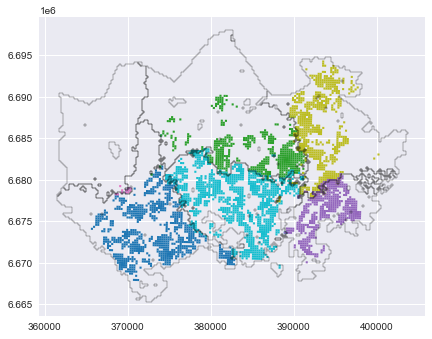

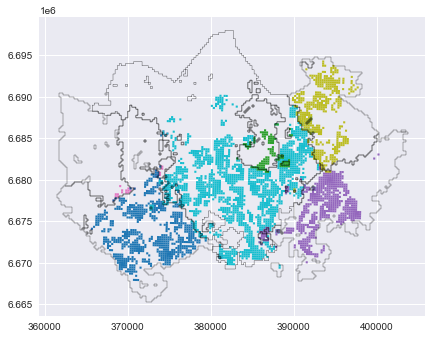

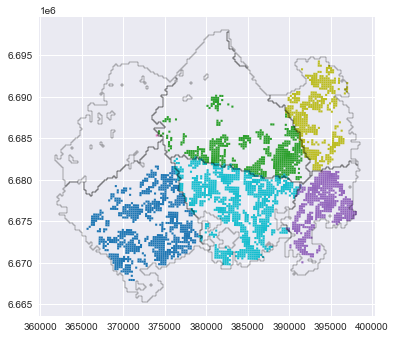

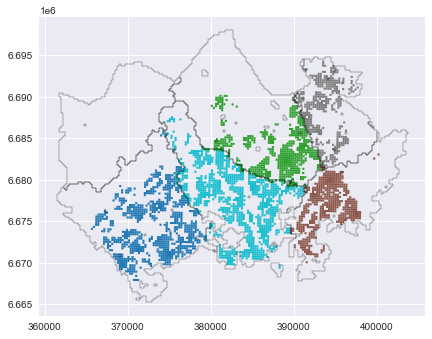

In [72]:
# intersect spatial join with population layer (pop layer with dominant area info)
join_car = gpd.sjoin(pop, grid_car, how = 'inner', op = 'intersects')

join_pt = gpd.sjoin(pop, grid_pt, how = 'inner', op = 'intersects')

join_wa = gpd.sjoin(pop, grid_wa, how = 'inner', op = 'intersects')

join_bi = gpd.sjoin(pop, grid_bi, how = 'inner', op = 'intersects')

# plots

ax = join_car.plot(column = 'index_right')
grid_car.plot(ax=ax, facecolor='None', edgecolor='black')
join_car.head()

ax1 = join_pt.plot(column = 'index_right')
grid_pt.plot(ax=ax1, facecolor='None', edgecolor='black')
join_pt.head()

ax2 = join_wa.plot(column = 'index_right')
grid_wa.plot(ax=ax2, facecolor='None', edgecolor='black')
join_wa.head()

ax3 = join_bi.plot(column = 'index_right')
grid_bi.plot(ax=ax3, facecolor='None', edgecolor='black')
grid_bi.to_file('results/empty_bike_area.gpkg', driver='GPKG')
join_bi.head()

In [73]:
# population by CAR dominant area

pop_car_area = pd.DataFrame()

for key, group in join_car.groupby('index_right'):
    '''Iterating over groups by dominance area to sum population'''
    
    pop_car_area.loc[key, 'car_dominance_area'] = key
    
    pop_car_area.loc[key, 'pop_car_sum'] = group['pop18'].sum()
    
# printing info
for area, pop in zip(pop_car_area['car_dominance_area'], pop_car_area['pop_car_sum']):
    print('{} dominance area has {} inhabitants'.format(area, pop))

# joining population by dominance area
grid_car = grid_car.merge(pop_car_area, left_on=grid_car.index, right_on=pop_car_area.index )

grid_car.head()

Espoo dominance area has 210788.0 inhabitants
Haltialan dominance area has 153737.0 inhabitants
Kallalahdenharju dominance area has 151589.0 inhabitants
Nuuksio dominance area has 1676.0 inhabitants
Sipoonkorpi dominance area has 173538.0 inhabitants
Urban dominance area has 425380.0 inhabitants


,key_0,geometry,car_dominance_area,pop_car_sum
0,Espoo,"MULTIPOLYGON (((383000.000 6669250.000, 382750...",Espoo,210788.0
1,Haltialan,"MULTIPOLYGON (((375000.000 6681250.000, 374750...",Haltialan,153737.0
2,Kallalahdenharju,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,151589.0
3,Nuuksio,"MULTIPOLYGON (((370250.000 6678250.000, 370000...",Nuuksio,1676.0
4,Sipoonkorpi,"MULTIPOLYGON (((400000.000 6678250.000, 399750...",Sipoonkorpi,173538.0


In [74]:
# population by PUBLIC TRANSPORT dominant area

pop_pt_area = pd.DataFrame()

for key, group in join_pt.groupby('index_right'):
    '''Iterating over groups by dominance area to sum population'''
    
    pop_pt_area.loc[key, 'pt_dominance_area'] = key
    
    pop_pt_area.loc[key, 'pop_pt_sum'] = group['pop18'].sum()
    
# printing info
for area, pop in zip(pop_pt_area['pt_dominance_area'], pop_pt_area['pop_pt_sum']):
    print('{} dominance area has {} inhabitants'.format(area, pop))

# joining population by dominance area
grid_pt = grid_pt.merge(pop_pt_area, left_on=grid_pt.index, right_on=pop_pt_area.index )

grid_pt.head()

Espoo dominance area has 184961.0 inhabitants
Haltialan dominance area has 27681.0 inhabitants
Kallalahdenharju dominance area has 210161.0 inhabitants
Nuuksio dominance area has 5495.0 inhabitants
Sipoonkorpi dominance area has 101582.0 inhabitants
Urban dominance area has 596594.0 inhabitants


,key_0,geometry,pt_dominance_area,pop_pt_sum
0,Espoo,"MULTIPOLYGON (((373000.000 6665250.000, 372750...",Espoo,184961.0
1,Haltialan,"MULTIPOLYGON (((387000.000 6681000.000, 386750...",Haltialan,27681.0
2,Kallalahdenharju,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,210161.0
3,Nuuksio,"MULTIPOLYGON (((365750.000 6673500.000, 365500...",Nuuksio,5495.0
4,Sipoonkorpi,"MULTIPOLYGON (((394500.000 6681000.000, 394250...",Sipoonkorpi,101582.0


In [75]:
# population by WALKING dominant area

pop_wa_area = pd.DataFrame()

for key, group in join_wa.groupby('index_right'):
    '''Iterating over groups by dominance area to sum population'''
    
    pop_wa_area.loc[key, 'wa_dominance_area'] = key
    
    pop_wa_area.loc[key, 'pop_wa_sum'] = group['pop18'].sum()
    
# printing info
for area, pop in zip(pop_wa_area['wa_dominance_area'], pop_wa_area['pop_wa_sum']):
    print('{} dominance area has {} inhabitants'.format(area, pop))

# joining population by dominance area
grid_wa = grid_wa.merge(pop_wa_area, left_on=grid_wa.index, right_on=pop_wa_area.index )

grid_wa.head()

Espoo dominance area has 203756.0 inhabitants
Haltialan dominance area has 161123.0 inhabitants
Kallalahdenharju dominance area has 168175.0 inhabitants
Nuuksio dominance area has 463.0 inhabitants
Sipoonkorpi dominance area has 111302.0 inhabitants
Urban dominance area has 423355.0 inhabitants


,key_0,geometry,wa_dominance_area,pop_wa_sum
0,Espoo,"POLYGON ((373000.000 6665250.000, 372750.000 6...",Espoo,203756.0
1,Haltialan,"POLYGON ((391750.000 6679500.000, 391500.000 6...",Haltialan,161123.0
2,Kallalahdenharju,"MULTIPOLYGON (((392000.000 6668500.000, 391750...",Kallalahdenharju,168175.0
3,Nuuksio,"MULTIPOLYGON (((366250.000 6678000.000, 366000...",Nuuksio,463.0
4,Sipoonkorpi,"MULTIPOLYGON (((392750.000 6680500.000, 392500...",Sipoonkorpi,111302.0


In [76]:
# population by BIKE FAST SPEED dominant area

pop_bi_area = pd.DataFrame()

for key, group in join_bi.groupby('index_right'):
    '''Iterating over groups by dominance area to sum population'''
    
    pop_bi_area.loc[key, 'bi_dominance_area'] = key
    
    pop_bi_area.loc[key, 'pop_bi_sum'] = group['pop18'].sum()
    
# printing info
for area, pop in zip(pop_bi_area['bi_dominance_area'], pop_bi_area['pop_bi_sum']):
    print('{} dominance area has {} inhabitants'.format(area, pop))

# joining population by dominance area
grid_bi = grid_bi.merge(pop_bi_area, left_on=grid_bi.index, right_on=pop_bi_area.index )

grid_bi

Espoo dominance area has 204353.0 inhabitants
Haltialan dominance area has 157285.0 inhabitants
Kallalahdenharju dominance area has 170640.0 inhabitants
Sipoonkorpi dominance area has 92055.0 inhabitants
Urban dominance area has 456757.0 inhabitants


,key_0,geometry,bi_dominance_area,pop_bi_sum
0,Espoo,"MULTIPOLYGON (((373000.000 6665250.000, 372750...",Espoo,204353.0
1,Haltialan,"MULTIPOLYGON (((391750.000 6679250.000, 391500...",Haltialan,157285.0
2,Kallalahdenharju,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,170640.0
3,Sipoonkorpi,"POLYGON ((394000.000 6681250.000, 393750.000 6...",Sipoonkorpi,92055.0
4,Urban,"MULTIPOLYGON (((383000.000 6669250.000, 382750...",Urban,456757.0


In [77]:
# saving dominant areas
#grid_car.to_file(r'results/car_dominant_areas.gpkg', driver='GPKG')
#grid_pt.to_file(r'results/pt_dominant_areas.gpkg', driver='GPKG')
#grid_wa.to_file(r'results/walk_dominant_areas.gpkg', driver='GPKG')
#grid_bi.to_file(r'results/bike_dominant_areas.gpkg', driver='GPKG')

### ***5. Adding green areas to dominant areas***

In [78]:
# Cliping the green areas

# dissolve column
grid['mask'] = 1

# dissolve grid for boundaries
grid_mask = grid.dissolve(by = 'mask')

# clip of green areas
green = gpd.clip(green, grid_mask)

In [79]:
grid_car.head()

,key_0,geometry,car_dominance_area,pop_car_sum
0,Espoo,"MULTIPOLYGON (((383000.000 6669250.000, 382750...",Espoo,210788.0
1,Haltialan,"MULTIPOLYGON (((375000.000 6681250.000, 374750...",Haltialan,153737.0
2,Kallalahdenharju,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,151589.0
3,Nuuksio,"MULTIPOLYGON (((370250.000 6678250.000, 370000...",Nuuksio,1676.0
4,Sipoonkorpi,"MULTIPOLYGON (((400000.000 6678250.000, 399750...",Sipoonkorpi,173538.0


,geometry,car_dominance_area,green_area,pop_car_sum,green_index
0,"MULTIPOLYGON (((383000.000 6669250.000, 382750...",Espoo,43790804.15,210788.0,207.748089
1,"MULTIPOLYGON (((375000.000 6681250.000, 374750...",Haltialan,77345708.06,153737.0,503.104055
2,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,17052125.78,151589.0,112.489203
3,"MULTIPOLYGON (((370250.000 6678250.000, 370000...",Nuuksio,88139982.13,1676.0,52589.488144
4,"MULTIPOLYGON (((400000.000 6678250.000, 399750...",Sipoonkorpi,53744005.65,173538.0,309.695892


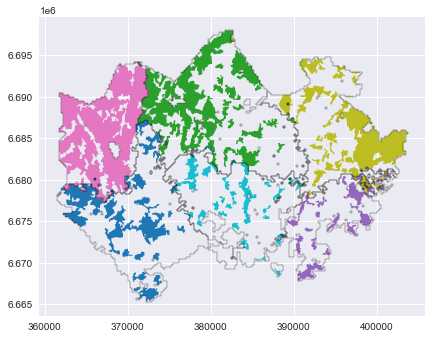

In [80]:
# CAR DOMINANCE AREAS

# clip with dominant areas
green_car = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=grid_car.crs)

#iterating over each dominant area to clip
for i in range(len(grid_car)):
    
    # getting each dominant area as geometry
    green_clip = grid_car.loc[i, 'geometry']
    
    # cliping each green areas by dominant area
    green_clip = gpd.clip(green[['geometry']], green_clip)
    
    # adding the name of the dominant area and pop
    green_clip['car_dominance_area'] = grid_car.loc[i, 'car_dominance_area']
    
    # dissolving by dominance area
    green_clip = green_clip.dissolve(by='car_dominance_area')
    
    # adding area
    green_clip['green_area'] = round(green_clip['geometry'].area, 2)
    
    # adding pop info
    green_clip = green_clip.merge(grid_car[['car_dominance_area','pop_car_sum']] , on='car_dominance_area')
    
    # appending to the new dataframe
    green_car = green_car.append(green_clip, ignore_index=True)

# plot
ax = green_car.plot(column ='car_dominance_area')
grid_car.plot(ax=ax, facecolor='None', edgecolor = 'black')

# calculating green accessibility index
green_car['green_index'] = green_car['green_area'] / green_car['pop_car_sum']

# adding to dominance areas
grid_car = grid_car[['geometry', 'car_dominance_area']]
green_car = green_car[['car_dominance_area','green_area', 'pop_car_sum', 'green_index']]

grid_car = grid_car.merge(green_car, on='car_dominance_area')

grid_car.head()    

,geometry,pt_dominance_area,green_area,pop_pt_sum,green_index
0,"MULTIPOLYGON (((373000.000 6665250.000, 372750...",Espoo,53550669.09,184961.0,289.524111
1,"MULTIPOLYGON (((387000.000 6681000.000, 386750...",Haltialan,5992313.56,27681.0,216.477496
2,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,38712749.53,210161.0,184.205202
3,"MULTIPOLYGON (((365750.000 6673500.000, 365500...",Nuuksio,56909796.42,5495.0,10356.650850
4,"MULTIPOLYGON (((394500.000 6681000.000, 394250...",Sipoonkorpi,30445851.98,101582.0,299.716997


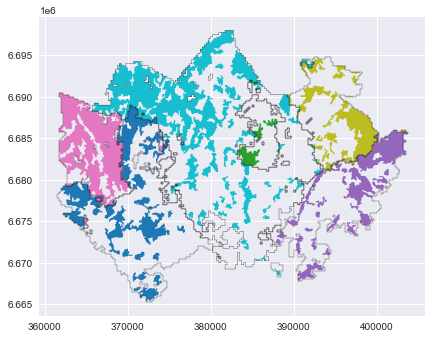

In [81]:
# PUBLIC TRANSPORT DOMINANCE AREAS

# clip with dominant areas
green_pt = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=grid_car.crs)

#iterating over each dominant area to clip
for i in range(len(grid_pt)):
    
    # getting each dominant area as geometry
    green_clip = grid_pt.loc[i, 'geometry']
    
    # cliping each green areas by dominant area
    green_clip = gpd.clip(green[['geometry']], green_clip)
    
    # adding the name of the dominant area and pop
    green_clip['pt_dominance_area'] = grid_pt.loc[i, 'pt_dominance_area']
    
    # dissolving by dominance area
    green_clip = green_clip.dissolve(by='pt_dominance_area')

    # adding area
    green_clip['green_area'] = round(green_clip['geometry'].area, 2)

    # adding pop info
    green_clip = green_clip.merge(grid_pt[['pt_dominance_area','pop_pt_sum']] , on='pt_dominance_area')

    # appending to the new dataframe
    green_pt = green_pt.append(green_clip, ignore_index=True)

# plot
ax = green_pt.plot(column ='pt_dominance_area')
grid_pt.plot(ax=ax, facecolor='None', edgecolor = 'black')

# calculating green accessibility index
green_pt['green_index'] = green_pt['green_area'] / green_pt['pop_pt_sum']

# adding to dominance areas
grid_pt = grid_pt[['geometry', 'pt_dominance_area']]
green_pt = green_pt[['pt_dominance_area','green_area', 'pop_pt_sum', 'green_index']]

grid_pt = grid_pt.merge(green_pt, on='pt_dominance_area')

grid_pt.head()   

,geometry,wa_dominance_area,green_area,pop_wa_sum,green_index
0,"POLYGON ((373000.000 6665250.000, 372750.000 6...",Espoo,46014860.15,203756.0,225.833154
1,"POLYGON ((391750.000 6679500.000, 391500.000 6...",Haltialan,64024120.59,161123.0,397.361771
2,"MULTIPOLYGON (((392000.000 6668500.000, 391750...",Kallalahdenharju,14249608.45,168175.0,84.730837
3,"MULTIPOLYGON (((366250.000 6678000.000, 366000...",Nuuksio,83462458.95,463.0,180264.490173
4,"MULTIPOLYGON (((392750.000 6680500.000, 392500...",Sipoonkorpi,24378622.77,111302.0,219.031309


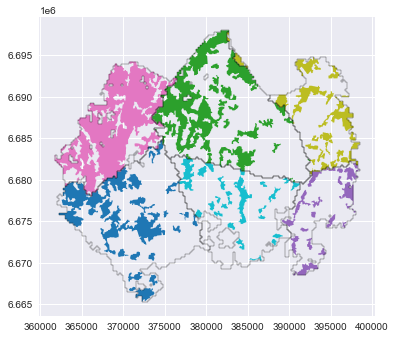

In [82]:
# WALKING DOMINANCE AREAS

# clip with dominant areas
green_wa = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=grid_car.crs)

#iterating over each dominant area to clip
for i in range(len(grid_wa)):
    
    # getting each dominant area as geometry
    green_clip = grid_wa.loc[i, 'geometry']
    
    # cliping each green areas by dominant area
    green_clip = gpd.clip(green[['geometry']], green_clip)
    
    # adding the name of the dominant area and pop
    green_clip['wa_dominance_area'] = grid_wa.loc[i, 'wa_dominance_area']
    
    # dissolving by dominance area
    green_clip = green_clip.dissolve(by='wa_dominance_area')

    # adding area
    green_clip['green_area'] = round(green_clip['geometry'].area, 2)

    # adding pop info
    green_clip = green_clip.merge(grid_wa[['wa_dominance_area','pop_wa_sum']] , on='wa_dominance_area')

    # appending to the new dataframe
    green_wa = green_wa.append(green_clip, ignore_index=True)

# plot
ax = green_wa.plot(column ='wa_dominance_area')
grid_wa.plot(ax=ax, facecolor='None', edgecolor = 'black')

# calculating green accessibility index
green_wa['green_index'] = green_wa['green_area'] / green_wa['pop_wa_sum']

# adding to dominance areas
grid_wa = grid_wa[['geometry', 'wa_dominance_area']]
green_wa = green_wa[['wa_dominance_area','green_area', 'pop_wa_sum', 'green_index']]

grid_wa = grid_wa.merge(green_wa, on='wa_dominance_area')

grid_wa.head()   

,geometry,bi_dominance_area,green_area,pop_bi_sum,green_index
0,"MULTIPOLYGON (((373000.000 6665250.000, 372750...",Espoo,50427416.65,204353.0,246.766217
1,"MULTIPOLYGON (((391750.000 6679250.000, 391500...",Haltialan,55154266.20,157285.0,350.664502
2,"MULTIPOLYGON (((391000.000 6667750.000, 390750...",Kallalahdenharju,38810810.66,170640.0,227.442632
3,"POLYGON ((394000.000 6681250.000, 393750.000 6...",Sipoonkorpi,29329885.69,92055.0,318.612630
4,"MULTIPOLYGON (((383000.000 6669250.000, 382750...",Urban,30116305.23,456757.0,65.935071


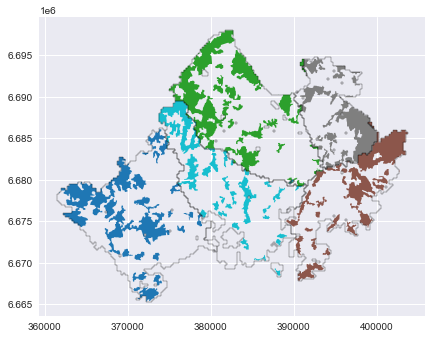

In [83]:
# CYCLING FAST SPEED DOMINANCE AREAS

# clip with dominant areas
green_bi = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=grid_car.crs)

#iterating over each dominant area to clip
for i in range(len(grid_bi)):
    
    # getting each dominant area as geometry
    green_clip = grid_bi.loc[i, 'geometry']
    
    # cliping each green areas by dominant area
    green_clip = gpd.clip(green[['geometry']], green_clip)
    
    # adding the name of the dominant area and pop
    green_clip['bi_dominance_area'] = grid_bi.loc[i, 'bi_dominance_area']
    
    # dissolving by dominance area
    green_clip = green_clip.dissolve(by='bi_dominance_area')

    # adding area
    green_clip['green_area'] = round(green_clip['geometry'].area, 2)

    # adding pop info
    green_clip = green_clip.merge(grid_bi[['bi_dominance_area','pop_bi_sum']] , on='bi_dominance_area')

    # appending to the new dataframe
    green_bi = green_bi.append(green_clip, ignore_index=True)

# plot
ax = green_bi.plot(column ='bi_dominance_area')
grid_bi.plot(ax=ax, facecolor='None', edgecolor = 'black')

# calculating green accessibility index
green_bi['green_index'] = green_bi['green_area'] / green_bi['pop_bi_sum']

# adding to dominance areas
grid_bi = grid_bi[['geometry', 'bi_dominance_area']]
green_bi = green_bi[['bi_dominance_area','green_area', 'pop_bi_sum', 'green_index']]

grid_bi = grid_bi.merge(green_bi, on='bi_dominance_area')

grid_bi.head()   

In [84]:
# saving dominant areas + populatio + green areas + index
grid_car.to_file(r'results/car_dominant_areas.gpkg', driver='GPKG')
grid_pt.to_file(r'results/pt_dominant_areas.gpkg', driver='GPKG')
grid_wa.to_file(r'results/walk_dominant_areas.gpkg', driver='GPKG')
grid_bi.to_file(r'results/bike_dominant_areas.gpkg', driver='GPKG')

### ***6. Formating maps***

In [85]:
import matplotlib.pyplot as plt
import contextily as ctx
import mapclassify

In [86]:
# reading base map files in Mercator 3857
sfp = r'data/sea.shp'
sea = gpd.read_file(sfp)

stfp = r'data/roads.shp'
streets = gpd.read_file(stfp)
streets = streets.to_crs(3857)

shfp = r'data/park_entrance.shp'
parks = gpd.read_file(shfp)
parks = parks.to_crs(3857)

mfp = r'data/metro.shp'
metro = gpd.read_file(mfp)

rfp = r'data/railway.shp'
railway = gpd.read_file(rfp)

print(sea.crs == streets.crs == metro.crs == railway.crs)
sea.crs.name

True


'WGS 84 / Pseudo-Mercator'

In [87]:
# project green index in mercator to make maps with basemap
grid_car = grid_car.to_crs(3857)
grid_pt = grid_pt.to_crs(3857)
grid_wa = grid_wa.to_crs(3857)
grid_bi = grid_bi.to_crs(3857)

In [88]:
green_wa.head()

,wa_dominance_area,green_area,pop_wa_sum,green_index
0,Espoo,46014860.15,203756.0,225.833154
1,Haltialan,64024120.59,161123.0,397.361771
2,Kallalahdenharju,14249608.45,168175.0,84.730837
3,Nuuksio,83462458.95,463.0,180264.490173
4,Sipoonkorpi,24378622.77,111302.0,219.031309


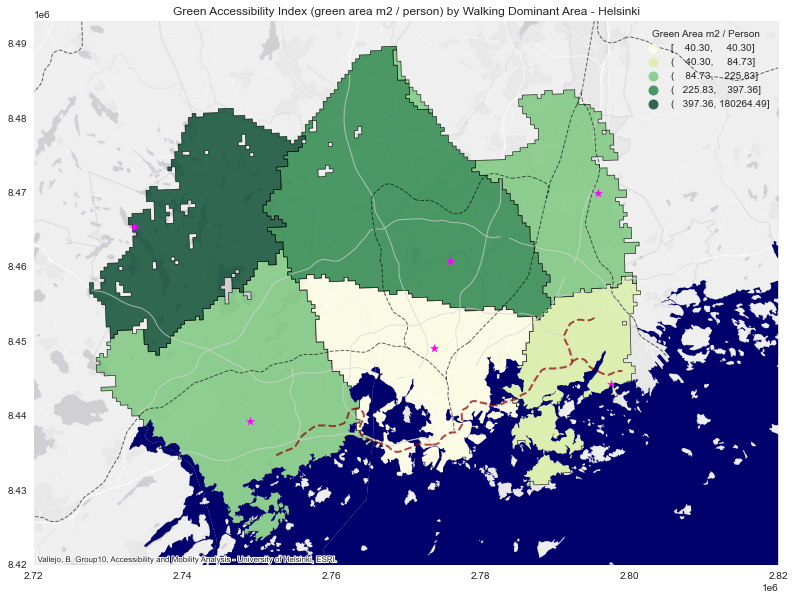

In [89]:
plt.style.use('seaborn-dark')

# WALKING GREEN ACCESS MAP

# create base ax
fig, ax = plt.subplots(figsize = [14,10])

# layers
grid_wa.plot(ax=ax, column = 'green_index',scheme = 'Natural_Breaks', k = 5, 
             cmap = 'YlGn',alpha = 0.8, edgecolor = 'black', linewidth = 0.7,
             legend = True)
parks.plot(ax=ax, color = 'magenta', marker = '*', markersize = 70, legend=True)
sea.plot(ax=ax, facecolor = '#00006c',  legend=True)
streets.plot(ax=ax, linewidth = 1, color = 'lightgray', alpha=0.7, legend=True)
railway.plot(ax=ax, linestyle = 'dashed',linewidth = 1, color = 'black', alpha=0.6, legend=True)
metro.plot(ax=ax, linestyle = 'dashed', linewidth = 2, color = 'darkred', alpha=0.7, legend=True)

ax.set_xlim(2720000, 2820000)
ax.set_ylim(8420000, 8493000)

ax.title.set_text('Green Accessibility Index (green area m2 / person) by Walking Dominant Area - Helsinki')

ax.get_legend().set_title('Green Area m2 / Person')
#ax.get_legend().set_bbox_to_anchor((1.18, 1))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, 
                attribution='Vallejo, B. Group10, Accessibility and Mobility Analysis - University of Helsinki, ESRI.')

plt.savefig('docs/walking_green_index.png', dpi=300)

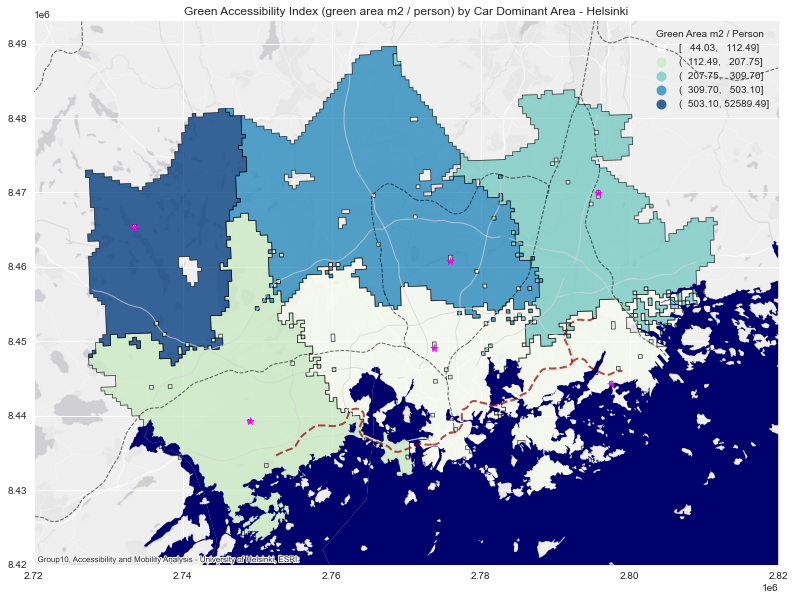

In [97]:
# CAR GREEN ACCESS MAP

# create base ax
fig, ax = plt.subplots(figsize = [14,10])

# layers
grid_car.plot(ax=ax, column = 'green_index',scheme = 'Natural_Breaks', k = 5, 
             cmap = 'GnBu',alpha = 0.8, edgecolor = 'black', linewidth = 0.7,
             legend = True)
parks.plot(ax=ax, color = 'magenta', marker = '*', markersize = 70, legend=True)
sea.plot(ax=ax, facecolor = '#00006c',  legend=True)
streets.plot(ax=ax, linewidth = 1, color = 'lightgray', alpha=0.7, legend=True)
railway.plot(ax=ax, linestyle = 'dashed',linewidth = 1, color = 'black', alpha=0.6, legend=True)
metro.plot(ax=ax, linestyle = 'dashed', linewidth = 2, color = 'darkred', alpha=0.7, legend=True)

ax.set_xlim(2720000, 2820000)
ax.set_ylim(8420000, 8493000)

ax.title.set_text('Green Accessibility Index (green area m2 / person) by Car Dominant Area - Helsinki')

ax.get_legend().set_title('Green Area m2 / Person')
#ax.get_legend().set_bbox_to_anchor((1.18, 1))

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, 
                attribution='Group10, Accessibility and Mobility Analysis - University of Helsinki, ESRI.')

plt.savefig('docs/car_green_index.png', dpi=300)

### ***7. Ploting differences***

In [90]:
# indexing for chart
grid_car['xspl'] = range(6)
grid_car = grid_car.sort_values('car_dominance_area')
#.set_index('car_dominance_area')
grid_car

,geometry,car_dominance_area,green_area,pop_car_sum,green_index,xspl
0,"MULTIPOLYGON (((2771078.539 8431738.683, 27705...",Espoo,43790804.15,210788.0,207.748089,0
1,"MULTIPOLYGON (((2754232.701 8455321.597, 27537...",Haltialan,77345708.06,153737.0,503.104055,1
2,"MULTIPOLYGON (((2787193.878 8429223.854, 27866...",Kallalahdenharju,17052125.78,151589.0,112.489203,2
3,"MULTIPOLYGON (((2744902.917 8448953.214, 27444...",Nuuksio,88139982.13,1676.0,52589.488144,3
4,"MULTIPOLYGON (((2804643.559 8450833.980, 28041...",Sipoonkorpi,53744005.65,173538.0,309.695892,4
5,"MULTIPOLYGON (((2775069.108 8432367.280, 27745...",Urban,18728799.22,425380.0,44.028396,5


In [91]:
grid_pt['xspl'] = range(6)
grid_pt = grid_pt.sort_values('pt_dominance_area')
#.set_index('pt_dominance_area')
grid_pt

,geometry,pt_dominance_area,green_area,pop_pt_sum,green_index,xspl
0,"MULTIPOLYGON (((2751326.735 8423051.462, 27508...",Espoo,5.355067e+07,184961.0,289.524111,0
1,"MULTIPOLYGON (((2778363.166 8455605.636, 27778...",Haltialan,5.992314e+06,27681.0,216.477496,1
2,"MULTIPOLYGON (((2787193.878 8429223.854, 27866...",Kallalahdenharju,3.871275e+07,210161.0,184.205202,2
3,"MULTIPOLYGON (((2736219.459 8439082.271, 27357...",Nuuksio,5.690980e+07,5495.0,10356.650850,3
4,"MULTIPOLYGON (((2793436.892 8456057.413, 27929...",Sipoonkorpi,3.044585e+07,101582.0,299.716997,4
5,"MULTIPOLYGON (((2771078.539 8431738.683, 27705...",Urban,1.139702e+08,596594.0,191.034755,5


In [92]:
grid_wa['xspl'] = range(6)
grid_wa = grid_wa.sort_values('wa_dominance_area')
#.set_index('wa_dominance_area')
grid_wa

,geometry,wa_dominance_area,green_area,pop_wa_sum,green_index,xspl
0,"POLYGON ((2751326.735 8423051.462, 2750826.612...",Espoo,46014860.15,203756.0,225.833154,0
1,"POLYGON ((2787998.949 8452876.165, 2787496.689...",Haltialan,64024120.59,161123.0,397.361771,1
2,"MULTIPOLYGON (((2789152.266 8430787.814, 27886...",Kallalahdenharju,14249608.45,168175.0,84.730837,2
3,"MULTIPOLYGON (((2736891.782 8448160.662, 27363...",Nuuksio,83462458.95,463.0,180264.490173,3
4,"MULTIPOLYGON (((2789949.012 8454948.214, 27894...",Sipoonkorpi,24378622.77,111302.0,219.031309,4
5,"POLYGON ((2771078.539 8431738.683, 2770577.766...",Urban,17059954.08,423355.0,40.297042,5


In [93]:
grid_bi.loc[5, 'bi_dominance_area'] = 'Nuuksio'
grid_bi.loc[5, 'green_index'] = 0
grid_bi['xspl'] = range(6)
grid_bi = grid_bi.sort_values('bi_dominance_area')
#.set_index('bi_dominance_area')
grid_bi

,geometry,bi_dominance_area,green_area,pop_bi_sum,green_index,xspl
0,"MULTIPOLYGON (((2751326.735 8423051.462, 27508...",Espoo,50427416.65,204353.0,246.766217,0
1,"MULTIPOLYGON (((2788013.831 8452373.087, 27875...",Haltialan,55154266.20,157285.0,350.664502,1
2,"MULTIPOLYGON (((2787193.878 8429223.854, 27866...",Kallalahdenharju,38810810.66,170640.0,227.442632,2
5,None,Nuuksio,NaN,NaN,0.000000,5
3,"POLYGON ((2792417.321 8456531.597, 2791914.800...",Sipoonkorpi,29329885.69,92055.0,318.612630,3
4,"MULTIPOLYGON (((2771078.539 8431738.683, 27705...",Urban,30116305.23,456757.0,65.935071,4


<AxesSubplot:>

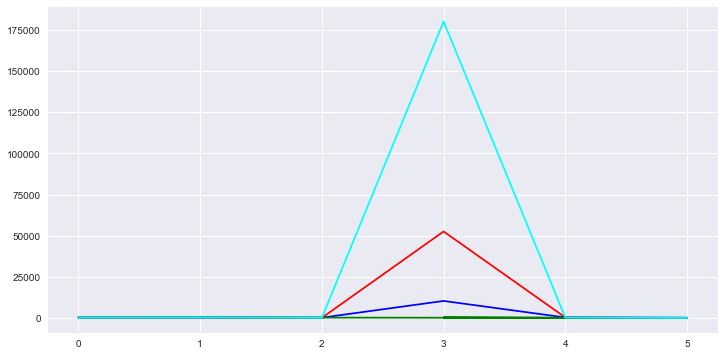

In [94]:
plt.style.use('seaborn')

# create base ax
fig, ax = plt.subplots(figsize = [12,6])

# plot
grid_car['green_index'].plot(c='red')
grid_pt['green_index'].plot(c='blue')
grid_bi['green_index'].plot(c='green')
grid_wa['green_index'].plot(c='cyan')

#plt.yscale('log')

#ax.set_xlim(2720000, 2820000)
#ax.set_ylim(0, 1000000)

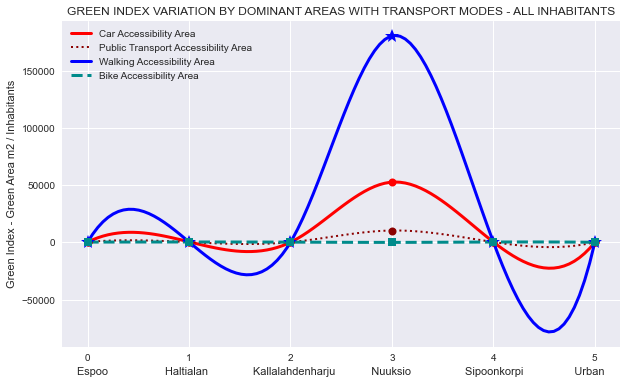

In [95]:
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

plt.style.use('seaborn')

# definying axis X
x = grid_car.xspl
xnew = np.linspace(x.min(), x.max(), 100) 

# definying axis Y
car = grid_car['green_index']
pt = grid_pt['green_index']
wa = grid_wa['green_index']
bi = grid_bi['green_index']

# definying smooth line
y_smooth1 = make_interp_spline(x, car)(xnew)
y_smooth2 = make_interp_spline(x, pt)(xnew)
y_smooth3 = make_interp_spline(x, wa)(xnew)
y_smooth4 = make_interp_spline(x, bi)(xnew)

# new DataFrame
new = pd.DataFrame()
new['xnew'] = xnew
new['car_s'] = y_smooth1
new['pt_s'] = y_smooth2
new['wa_s'] = y_smooth3
new['bi_s'] = y_smooth4

new = new.set_index('xnew')

# plotting data
axcar = new['car_s'].plot(figsize=[10,6], style = '-r', lw = 3, legend = True, label = 'Car Accessibility Area')
axypt = new['pt_s'].plot(style = ':', lw = 2, c = 'darkred', legend = True, label = 'Public Transport Accessibility Area')
axwa = new['wa_s'].plot(style = '-b', lw = 3, legend = True, label = 'Walking Accessibility Area')
axbi = new['bi_s'].plot(style = '--', lw = 3, c = 'darkcyan', legend = True, label = 'Bike Accessibility Area')

# plotting markers
grid_car['green_index'].plot(style = 'ro', markersize = 8)
grid_pt['green_index'].plot(style = 'o', c = 'darkred', markersize = 8)
grid_wa['green_index'].plot(style = '*', c = 'blue', markersize = 14)
grid_bi['green_index'].plot(style = 's', c = 'darkcyan', markersize = 8)

#plt.yscale('log')

plt.xlabel('Espoo                   Haltialan               Kallalahdenharju            Nuuksio                  Sipoonkorpi                 Urban')
plt.ylabel('Green Index - Green Area m2 / Inhabitants')
plt.title('GREEN INDEX VARIATION BY DOMINANT AREAS WITH TRANSPORT MODES - ALL INHABITANTS')

plt.savefig('docs/all_pop_green_index_variation.png', dpi=300)